# Time Savings, Speed and Volume Exploration
-----
Additional time and speed exploration

In [5]:
library(ggplot2)
library(RSQLCipher)
suppressWarnings(library(tidyverse))
select <- dplyr::select
library(matrixStats)
library(quantreg)
# import income functions
suppressMessages(source("../../src/income.R"))

In [6]:
acs = read_csv("../../data/block_group_census_estimates_wide_wsdot_bins.csv", col_types="cccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf, !is.na(med_inc)) %>%
    mutate(fips = fips_code) 
#%>% select(-fips_code)

acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [7]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
db_path = "../../../db/hot_2.1.db"
trips = load_table(db_path, "trips_2pct")
full_trips = load_table(db_path, "trips_linked")

In [8]:
speeds_original = read_csv("../../../data/concatenated_405_speeds_5am_to_8pm_1min.csv", na = "-86400")
trip_times_original = read_csv("../../../data/concatenated_405_travel_times_5am_to_8pm_5_min.csv", na = "-86400")
volumes_original = read_csv("../../../data/concatenated_405_volumes_5am_to_8pm_1min.csv", na = "-86400")

Parsed with column specification:
cols(
  .default = col_double(),
  Time = col_datetime(format = "")
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  Time = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  Time = col_datetime(format = "")
)
See spec(...) for full column specifications.


In [9]:
speeds <- speeds_original
speeds$Time <- format(as.POSIXct(speeds_original$Time,format="%Y-%m-%d %H:%M:%S"),"%m-%d %H:%M")
trip_times <- trip_times_original
trip_times$Time <- format(as.POSIXct(trip_times_original$Time,format="%m/%d/%Y %H:%M"),"%m-%d %H:%M")
volumes <- volumes_original
volumes$Time <- format(as.POSIXct(volumes_original$Time,format="%Y-%m-%d %H:%M:%S"),"%m-%d %H:%M")


In [10]:
speeds_mean <- speeds %>%
    select(-Time) %>%
    colMeans() %>%
    t() %>%
    as.data.frame()
vol_means <- volumes %>%
    select(-Time) %>%
    colMeans() %>%
    t() %>%
    as.data.frame()

trip_times %>%
    select(-Time) %>% 
    as.matrix() %>%
    colMeans(na.rm = TRUE) %>%
    as.data.frame() %>%
    t()

,GP_12_12,HOV_12_12,GP_11_11,HOV_11_11,GP_11_12,HOV_11_12,GP_14_14,HOV_14_14,GP_14_15,HOV_14_15,⋯,GP_16_23,HOV_16_23,GP_23_23,HOV_23_23,GP_21_23,HOV_21_23,GP_20_23,HOV_20_23,GP_19_23,HOV_19_23
.,32.30597,27.17147,40.01096,34.55053,72.30565,61.71077,120.7375,103.7224,218.1233,181.0587,⋯,663.6554,517.3096,157.625,109.5044,192.5298,139.0723,389.9604,294.959,535.2235,403.7188


In [11]:
temp <- speeds %>%
    select(GP_03, Time) %>%
    rename(GP_03_speed = GP_03)

temp2 <- volumes %>%
    select(GP_03, Time) %>%
    rename(GP_03_vol = GP_03)

gp_03_speed_vol <- merge(temp, temp2, by = "Time")

gp_03_speed_vol$Time <- format(as.POSIXct(gp_03_speed_vol$Time,format="%m-%d %H:%M"))

gp_03_speed_vol$hour <- hour(gp_03_speed_vol$Time)  
gp_03_speed_vol$minute <- minute(gp_03_speed_vol$Time)  



### Points of speed over time hourminute

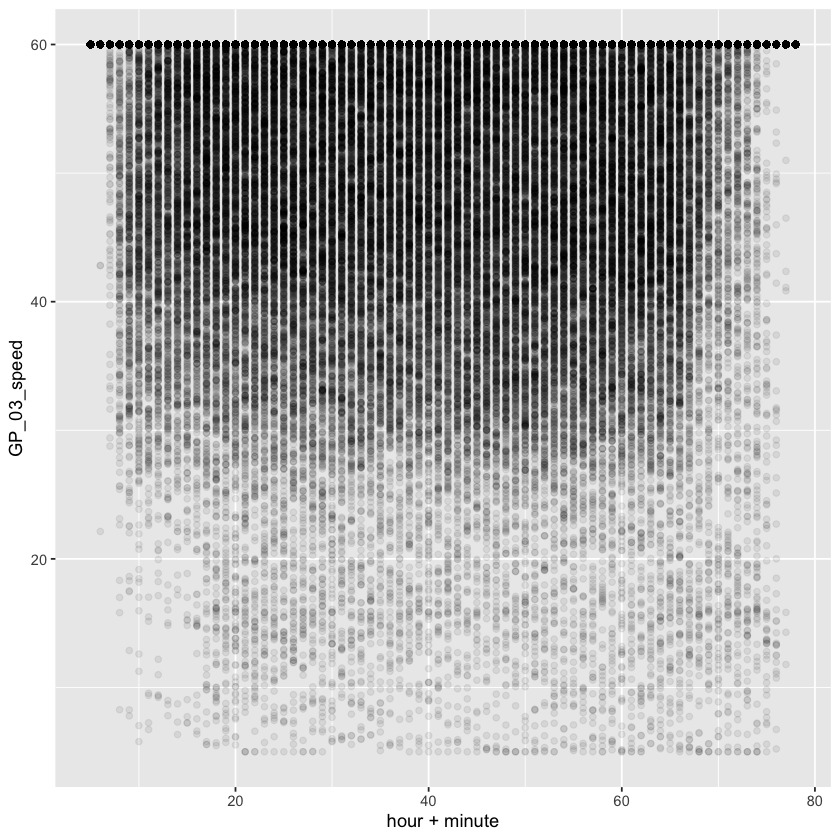

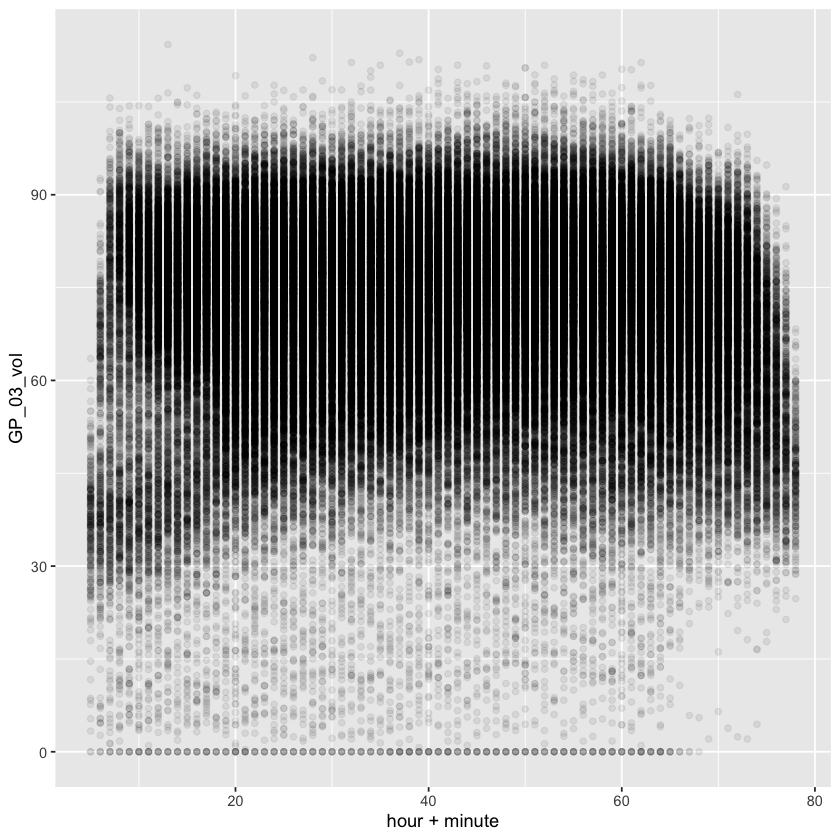

In [12]:
ggplot(gp_03_speed_vol, aes(x = hour + minute, y = GP_03_speed)) + 
    geom_point(alpha = .07)

ggplot(gp_03_speed_vol, aes(x = hour + minute, y = GP_03_vol)) + 
    geom_point(alpha = .07)

### Cool example of speed and volume curve 
Caps at 60 mph since everything above is technically "illegal"

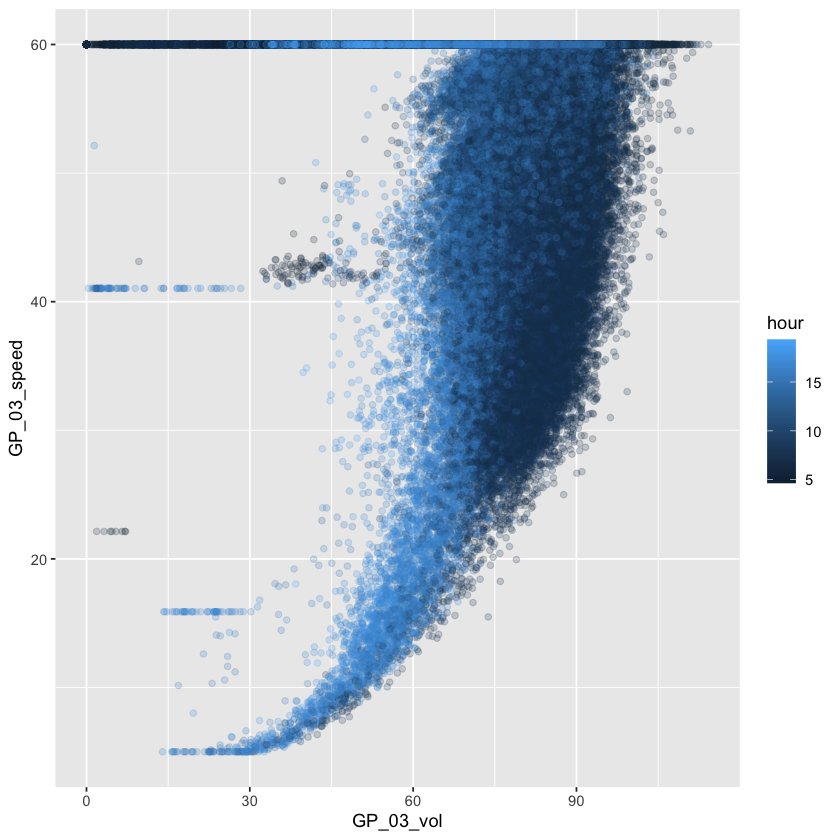

In [13]:
ggplot(gp_03_speed_vol, aes(x = GP_03_vol, y = GP_03_speed, color = hour)) + 
    geom_point(alpha = .2) 

## Regression

In [14]:
# gather trip data
corridor_trips <- trips %>%
    filter(entry_plaza == 3,
          exit_plaza == 12) %>%
    execute

corridor_trips$entry_time <- as_datetime(corridor_trips$entry_time, tz = "UTC")
corridor_trips$entry_time  <- format(as.POSIXct(corridor_trips$entry_time ,format="%Y-%m-%d %H:%M:%S"),"%m-%d %H:%M")

head(corridor_trips)

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,med_inc,population,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104026666,2689,0.75,01-02 11:49,1514894647,3,12,0,7.156660e+18,6.091979e+18,⋯,0.07550645,0.03499079,0.000000000,0.00000000,0.00000000,0.00000000,28292,1285,0.00000000,0.5112840
104027300,2689,0.75,01-02 15:51,1514909110,3,12,0,-4.304384e+18,-4.107471e+18,⋯,0.20305981,0.16272601,0.119610570,0.09040334,0.06675939,0.03894298,57484,1271,0.04248623,0.9055862
104035741,2689,1.25,01-02 16:16,1514910652,3,12,0,-6.743599e+18,3.790545e+18,⋯,0.12860310,0.22172949,0.126385809,0.13303769,0.14634146,0.04434590,93750,1473,0.04209097,0.7291242
104037535,2689,0.75,01-02 15:49,1514909010,3,12,0,-6.803134e+18,3.159863e+18,⋯,0.22044728,0.14856230,0.148562300,0.17412141,0.05910543,0.04792332,89352,1711,0.16540035,0.7358270
104037895,2689,0.75,01-02 06:38,1514875922,3,12,0,4.705629e+18,-1.829844e+18,⋯,0.02827381,0.06547619,0.005952381,0.03720238,0.17261905,0.50892857,205300,1921,0.22332119,0.7194170
104040215,2689,0.75,01-02 15:39,1514908396,3,12,0,-6.187511e+18,-9.205921e+18,⋯,0.22766571,0.17002882,0.187319885,0.03890490,0.00000000,0.00000000,54567,2183,0.00000000,0.5648191


In [24]:
# gather speed and volume
corridor_speeds <- speeds %>%
    select(GP_03, HOV_03, Time) %>%
    rename(gp_speed = GP_03,
          hov_speed = HOV_03)

corridor_vol <- volumes %>%
    select(GP_03, HOV_03, Time) %>%
    rename(gp_vol = GP_03,
          hov_vol = HOV_03)

actual_tt <- trip_times %>%
    select(GP_03_12, HOV_03_12, Time) %>%
    rename(gp_tt = GP_03_12,
          hov_tt = HOV_03_12) %>%
    mutate(tt_savings = gp_tt - hov_tt)

head(actual_tt)
# actual_tt$hour_min <- format(as.POSIXct(actual_tt$Time,format="%m-%d %H:%M"),"%H%M" )
# actual_tt$Time <- as.POSIXct(actual_tt$Time, format = "%m-%d %H:%M")
# attr(actual_tt$Time, "tzone") <- "UTC"
#  actual_tt$Time <- as.numeric(actual_tt$Time)
# head(actual_tt)

gp_tt,hov_tt,Time,tt_savings
<dbl>,<dbl>,<chr>,<dbl>
922.8,922.8,01-01 05:00,0
922.8,922.8,01-01 05:05,0
922.8,922.8,01-01 05:10,0
922.8,922.8,01-01 05:15,0
922.8,922.8,01-01 05:20,0
922.8,922.8,01-01 05:25,0


In [29]:
# estimated travel times
corridor_times <- merge(corridor_speeds, corridor_vol, by = "Time")
corridor_times <- merge(corridor_times, actual_tt, by = "Time")

corridor_times$Time <- format(as.POSIXct(corridor_times$Time,format="%m-%d %H:%M"),"%m-%d %H:%M" )

corridor_times$hour_min <- format(as.POSIXct(corridor_times$Time,format="%m-%d %H:%M"),"%H%M" )

est_tt <- lm(tt_savings ~ hov_vol + gp_speed + hov_speed + gp_vol + factor(hour_min) - 1, corridor_times)

In [3]:
# estimated reliability
reliability <- read_csv("../../data/expected_reliability_savings.csv")
head(reliability)

Parsed with column specification:
cols(
  tod = col_double(),
  entry = col_double(),
  exit = col_double(),
  trip_id = col_character(),
  reliability = col_double()
)


tod,entry,exit,trip_id,reliability
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
500,3,3,03_03,0
500,3,5,03_05,0
500,3,6,03_06,0
500,3,7,03_07,0
500,3,9,03_09,0
500,3,10,03_10,0



Call: rq(formula = tt_savings ~ Time, data = actual_tt)

tau: [1] 0.5

Coefficients:
            Value      Std. Error t value    Pr(>|t|)  
(Intercept) -251.04836   30.87803   -8.13032    0.00000
Time           0.00000    0.00000    8.37716    0.00000


Call: rq(formula = tt_savings ~ Time, tau = 0.8, data = actual_tt)

tau: [1] 0.8

Coefficients:
            Value       Std. Error  t value     Pr(>|t|)   
(Intercept) -6973.21176  1171.64299    -5.95165     0.00000
Time            0.00000     0.00000     6.30038     0.00000

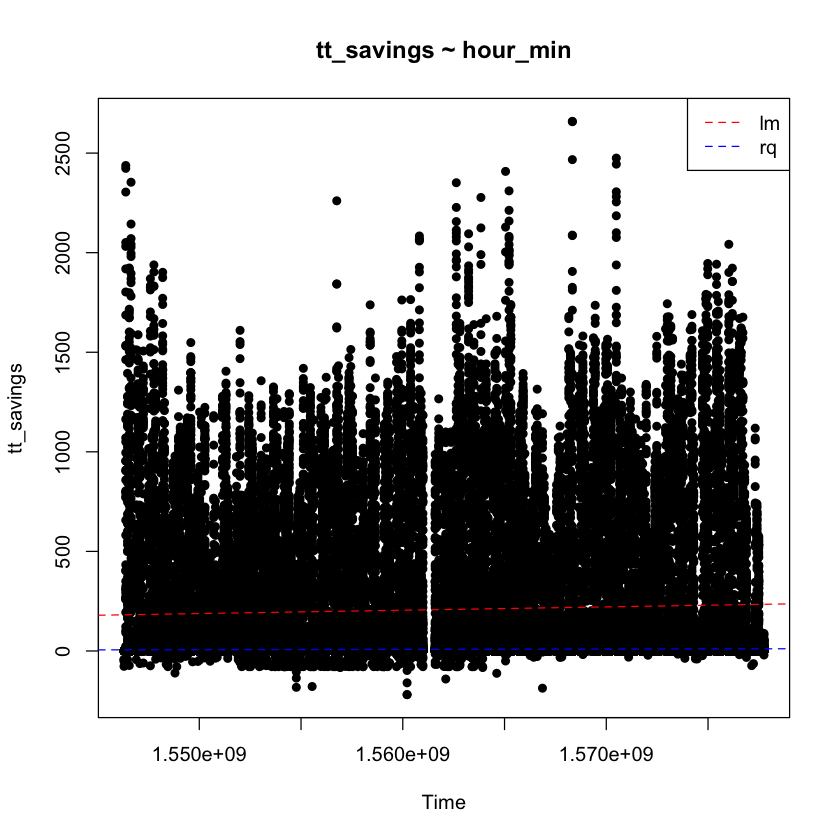

In [98]:
plot(tt_savings ~ Time, data = actual_tt, pch = 16, main = "tt_savings ~ hour_min")
abline(lm(tt_savings ~ Time, data = actual_tt), col = "red", lty = 2)
abline(rq(tt_savings ~ Time, data = actual_tt), col = "blue", lty = 2)
legend("topright", legend = c("lm", "rq"), col = c("red", "blue"), lty = 2)